In [156]:
import pandas as pd
import numpy as np

df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
print(f'Total number of rows: {len(df_boston)}')

Total number of rows: 1122558


In [ ]:
df_boston.head() 

In [157]:
df_boston['user_type'].unique()

<StringArray>
['Subscriber', 'Customer']
Length: 2, dtype: string

# Preprocessing
### Set data type of 'end_station_id'

In [158]:
df_boston['end_station_id'].unique()

<StringArray>
[ '96',  '95',  '68',  '88',  '76', '118',  '75',  '67',  '36',  '23',
 ...
 '169', '174', '175', '159', '171', '178', '176', '179', '180', '177']
Length: 157, dtype: string

In [ ]:
# Value '\\N' seems to be anomaly -> occurs only once, so drop!
num_occurences = len(df_boston.loc[df_boston["end_station_id"] == "\\N"])
print(f'Number of "\\\\N" occurences in end_station_id column: {num_occurences}')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)

# now set column to dtype np.int64
df_boston = df_boston.astype({'end_station_id': np.int64})
df_boston.info()

### Set data type of time columns

In [ ]:
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.dtypes

#### Check if station id and names are unique tuples

In [ ]:
# len(df_boston['start_station_name'].unique())
is_unique = True
i = 0
all_station_ids = df_boston['start_station_id'].unique()

while i < len(all_station_ids) & is_unique:
    is_unique = len(df_boston.loc[df_boston['start_station_id'] == i]['start_station_name'].unique()) == 1
    i += 1

print("Station IDs and names are unique", is_unique)


In [ ]:
# Check if station id and name always match
unique_start_tuples = np.unique(df_boston[['start_station_id', 'start_station_name']].values.astype('str'), axis=0)
unique_start_tuples

In [ ]:
#TODO: check for entire duplicates (also end stations)
unique_start_tuples[:,0:1]
u, c = np.unique(unique_start_tuples[:,0:1], return_counts=True)
dup = u[c > 1]
dup 

# Feature Engineering
#### Calculate trip_length 

In [ ]:
df_boston['trip_length'] = (df_boston['end_time'] - df_boston['start_time'])
df_boston['trip_length'] = df_boston['trip_length'] / np.timedelta64(1, 's')
df_boston.head()

# First Data Exploration
### Understanding the revenue modell

![caption](data/thehubway_revenue_modell_2015.png)

In [ ]:
# Pricing info pulled from: https://web.archive.org/web/20150206035343/http://www.thehubway.com:80/pricing
# INFO: bluebikes was previously called 'thehubway', see https://en.wikipedia.org/wiki/Bluebikes
# ASSUMTION: The revenue modell did not change over the year 2015. This was checked through all entries of the wayback-machine, which occured in 7 day intervalls. We can be pretty certain of this. 


# Get # of subscribers and customers
print(df_boston.groupby('user_type').size())
# TODO: Include this in revenue modell

# Thoughts on the revenue modell: We don't see individual user-ids for each ride. This means that we can only infer the "revenue" generated by each trip through the respective user_type.
# E.g. -> if we have 10 subscribers for a given timeframe, who undertake 100 trips, each trip would generate 1/10 of the users membership fee in the given timeframe
# Membership numbers for 2015: https://web.archive.org/web/20160208155519/http://www.thehubway.com/mediakit -> anual members: 13.248, Causal Passes: 102.445 (24 & 72 Hours) with a total of 1,1319,310 Trips (???)

no_trips_from_dataset_2015 = 11319310
no_trips_from_website_2015 = len(df_boston)
print(f'We only have {no_trips_from_website_2015/no_trips_from_dataset_2015} of the data!')

# Big Open Question: How should we deal with the missing data? (we only have 1/10 of the trip data apparently) ? -> https://s3.amazonaws.com/hubway-data/index.html this contains the raw data, it appears that there are a lot more than 112k rides..
# Open Question: How should we include the membership fees and casual passes costs in the revenue modell?


# get proprtion all the rides who might incur overtime fees (trip_length >30 min) to understand if this usage pattern is relevant for the revenue model
proportion_overtime_rides = len(df_boston[df_boston['trip_length'] >= (30*60)]) / len(df_boston) 
print(proportion_overtime_rides)

# Conclusion: Around 7% of rides were overtime -> we should include this in the revenue modell
# TODO: Engineer the following features for the revenue modell: revenue_through_overtime (calculated on the basis of trip_duration)


### merging of boston station dataset and the df_boston data

In [ ]:
#boston blue bikes stations data
df_stations_data = pd.read_csv('./data/current_bluebikes_stations.csv', header=1)
df_january = pd.read_csv('./data/201501-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_sep = pd.read_csv('./data/201509-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_july = pd.read_csv('./data/201507-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_oct = pd.read_csv('./data/201510-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_dec = pd.read_csv('./data/201512-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
unique_stations_external=np.unique(np.concatenate((df_january[['start station id', 'start station latitude', 'start station longitude']].values, df_january[['end station id', 'end station latitude', 'end station longitude']].values,df_july[['start station id', 'start station latitude', 'start station longitude']].values, df_july[['end station id', 'end station latitude', 'end station longitude']].values, df_sep[['start station id', 'start station latitude', 'start station longitude']].values, df_sep[['end station id', 'end station latitude', 'end station longitude']].values, df_oct[['start station id', 'start station latitude', 'start station longitude']].values, df_oct[['end station id', 'end station latitude', 'end station longitude']].values, df_dec[['start station id', 'start station latitude', 'start station longitude']].values, df_dec[['end station id', 'end station latitude', 'end station longitude']].values)), axis=0)

In [ ]:
unique_stations_original=np.unique(np.concatenate((df_boston['start_station_name'].values, df_boston['end_station_name'].values)))
print(f'# stations from original data: {len(unique_stations_original)} | # stations from external data: {len(unique_stations_external)}')
df_unique_stations = pd.DataFrame(unique_stations_external, columns=['station_id', 'station_latitude', 'station_longitude'])

In [ ]:
df_unique_stations.columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='start_station_id')
df_unique_stations.columns = ['end_station_id', 'end_station_latitude', 'end_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='end_station_id')
df_boston.info()

In [ ]:
df_boston.head()

In [ ]:
unique_stations_original=np.unique(np.concatenate((df_boston['start_station_name'].values, df_boston['end_station_name'].values)))
unique_stations_external = df_stations_data['Name'].values

In [ ]:
print(f"#stations in stations dataset: {len(df_stations_data.loc[df_stations_data['Deployment Year'] < 2015.0])}")
print(f"#stations in original dataset: {len(unique_stations_original)}")

In [ ]:
stations_no_match = list(filter(lambda x: not(np.any(unique_stations_external == x)), unique_stations_original))
len(stations_no_match)

stations_no_match


In [ ]:
stations_match = list(filter(lambda x: np.any(unique_stations_external == x), unique_stations_original))
stations_match

# Plot start & end stations

In [ ]:
len(df_boston)
df_boston.head()

In [148]:
df_start = df_boston.groupby(['start_station_id','start_station_latitude', 'start_station_longitude']).size().reset_index(name='count_start')

In [149]:
df_end = df_boston.groupby(['end_station_id','end_station_latitude', 'end_station_longitude']).size().reset_index(name='count_end')

In [144]:
df_start = df_start.sort_values('start_station_id')
df_end = df_end.sort_values('end_station_id')

df_ratio = df_start.copy()
df_ratio['count_end'] = df_end['counts_end']
df_ratio["ratio"] = df_start['counts_start']/df_end['counts_end']


df_ratio.sort_values('ratio').describe()


,start_station_id,start_station_latitude,start_station_longitude,counts_start,count_end,ratio
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,85.314103,42.355539,-71.089556,7195.878205,7195.878205,1.018733
std,49.862754,0.021187,0.028647,5680.263408,5803.203988,0.120328
min,1.000000,42.303469,-71.160411,46.000000,39.000000,0.363636
25%,43.750000,42.343900,-71.113428,2832.500000,2611.000000,0.968435
50%,84.500000,42.354157,-71.090935,6300.500000,6254.500000,1.005770
75%,124.250000,42.369364,-71.065351,10356.500000,10565.500000,1.053639
max,180.000000,42.404490,-71.028664,30798.000000,31284.000000,1.625000


In [145]:
df_start

,start_station_id,start_station_latitude,start_station_longitude,counts_start
0,1,42.387151,-71.075978,56
1,3,42.340021,-71.100812,5018
2,4,42.345392,-71.069616,9512
3,5,42.341814,-71.090179,6175
4,6,42.361174,-71.065142,13018
...,...,...,...,...
151,176,42.386748,-71.119019,287
152,177,42.362648,-71.100061,858
153,178,42.359573,-71.101295,1197
154,179,42.355601,-71.103945,894


In [155]:

df_sum_station = df_end.merge(df_start)
df_sum_station 

,end_station_id,end_station_latitude,end_station_longitude,counts,start_station_id,start_station_latitude,start_station_longitude
0,29,42.363732,-71.124565,3194,82,42.339335,-71.13493


In [ ]:
df_station_share = df_start.copy()
df_station_share['total_rides'] = df_start['counts_start'] + df_end['counts_end']
yearly_total_rides = sum(df_station_share['total_rides'])
df_station_share['share'] = (df_station_share['total_rides'] / yearly_total_rides)*100
df_station_share.sort_values('share', ascending=False).head(5)

In [ ]:
import seaborn as sns

<AxesSubplot: xlabel='start_station_id', ylabel='share'>

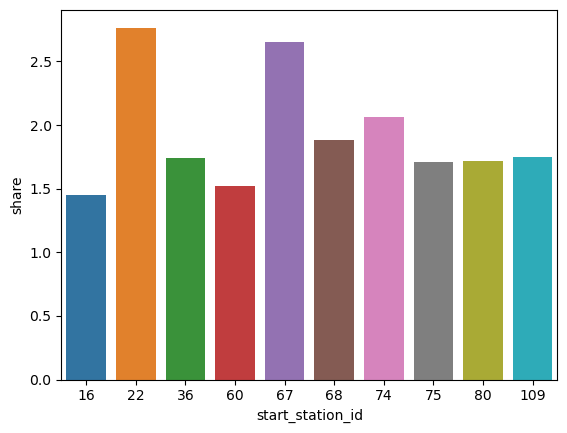

In [ ]:
sns.barplot(df_station_share.loc[df_station_share['counts_start'] > 15000 ], x = "start_station_id", y = "share" )

In [ ]:
import plotly.express as px

In [ ]:

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_start, 
                        lat="start_station_latitude", 
                        lon="start_station_longitude", 
                        color='counts_start',
                        color_continuous_scale=color_scale,
                        size='counts_start',
                        zoom=8, 
                        height=800,
                        width=800)


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_end, 
                        lat="end_station_latitude", 
                        lon="end_station_longitude", 
                        color='counts_end',
                        color_continuous_scale=color_scale,
                        size='counts_end',
                        zoom=8, 
                        height=800,
                        width=800)


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [118]:
#number of trips between a start and end station

df_trips = df_boston.groupby(['start_station_id','end_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']).size().reset_index(name='count_trips')

df_trips = df_trips.sort_values('count_trips', ascending = False)

df_trips.index = range(0, len(df_trips))

df_trips.head(10)

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,count_trips
0,118,100,42.397828,-71.130516,42.396969,-71.123024,3020
1,100,118,42.396969,-71.123024,42.397828,-71.130516,2755
2,114,100,42.402763,-71.126908,42.396969,-71.123024,2047
3,67,53,42.358100,-71.093198,42.350851,-71.089886,2026
4,40,22,42.363871,-71.050877,42.352175,-71.055547,1982
5,67,68,42.358100,-71.093198,42.365070,-71.103100,1845
6,53,67,42.350851,-71.089886,42.358100,-71.093198,1783
7,22,40,42.352175,-71.055547,42.363871,-71.050877,1741
8,68,67,42.365070,-71.103100,42.358100,-71.093198,1610
9,20,22,42.359770,-71.051601,42.352175,-71.055547,1531


In [119]:
import folium


avg_lat = df_trips['start_station_latitude'].mean()
avg_long = df_trips['start_station_longitude'].mean()

m = folium.Map(location=[avg_lat, avg_long], zoom_start=15)

points = []

df_top_trips = df_trips.head(10)


for i in range(0,len(df_top_trips)):
    points.append([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']])
    points.append([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']])
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']],popup=(df_top_trips.iloc[i]['start_station_id'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='green',prefix='fa', icon='bicycle')).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']],popup=(df_top_trips.iloc[i]['end_station_id'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='red',prefix='fa', icon='bicycle')).add_to(m)
    points = [] #if points is not reseted then each station will be connected with every other station in array

m 

In [ ]:
#PROBLEM: 1. no correct image of most frequently used routes -> adding up both directios and getting most commonly used routes
#PROBLEM: 2. trips laying on top of each other


In [139]:
#df_trips.loc[df_trips['count_trips'] > 1000]
len(df_trips)

18161

In [137]:
df_top_trips = df_trips.head(47).copy() #most common trips ignoring direction of trip, filter is 47 as we only use values above 1000 

for j in range(0, len(df_top_trips)):
    if j < len(df_top_trips):
        for i in range (0, len(df_top_trips)):
            if i < len(df_top_trips):
                if df_top_trips.at[j,'start_station_id'] == df_top_trips.at[i, 'end_station_id'] and df_top_trips.at[i,'start_station_id'] == df_top_trips.at[j, 'end_station_id']:
                    df_top_trips.at[j, 'count_trips'] = df_top_trips.at[i, 'count_trips'] + df_top_trips.at[j, 'count_trips']
                    df_top_trips = df_top_trips.drop(i)
                df_top_trips.index = range(0, len(df_top_trips))


df_top_trips = df_top_trips.sort_values('count_trips', ascending = False)
df_top_trips.index = range(0, len(df_top_trips))
df_top_trips = df_top_trips.rename(columns = {'start_station_id' : 'Station_A', 'end_station_id' : 'Station_B'})
df_top_trips = df_top_trips.head(11) #above 2300 total trips and close to top 10 
df_top_trips


,Station_A,Station_B,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,count_trips
0,118,100,42.397828,-71.130516,42.396969,-71.123024,5775
1,67,53,42.358100,-71.093198,42.350851,-71.089886,3809
2,40,22,42.363871,-71.050877,42.352175,-71.055547,3723
3,67,68,42.358100,-71.093198,42.365070,-71.103100,3455
4,114,100,42.402763,-71.126908,42.396969,-71.123024,3202
5,20,22,42.359770,-71.051601,42.352175,-71.055547,2995
6,67,75,42.358100,-71.093198,42.363465,-71.100573,2904
7,67,74,42.358100,-71.093198,42.373268,-71.118579,2711
8,67,107,42.358100,-71.093198,42.362500,-71.088220,2617
9,22,109,42.352175,-71.055547,42.365942,-71.060515,2387


In [138]:
#mapping the top trips 


avg_lat = df_trips['start_station_latitude'].mean()
avg_long = df_trips['start_station_longitude'].mean()

m = folium.Map(location=[avg_lat, avg_long], zoom_start=15)

points = []


for i in range(0,len(df_top_trips)):
    points.append([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']])
    points.append([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']])
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']],popup=(df_top_trips.iloc[i]['Station_A'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='blue',prefix='fa', icon='bicycle')).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']],popup=(df_top_trips.iloc[i]['Station_B'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='blue',prefix='fa', icon='bicycle')).add_to(m)
    points = [] #if points is not reseted then each station will be connected with every other station in array

m 

In [ ]:
#findings: near universities (harvard and mit) as well as around citycenter(haymarket) and the trainstations (north and south)